# Initial exploration of CORD_19 covid literature dataset

### Background

One of the most amazing things about the response to the COVID-19 pandemic has been theamount of research released on extremely short timelines. While this is an incredible human accomplishment, the generation of this much science exacerbates an existing problem facing many scientific researchers: it is often impossible to read every piece of potentially relevant research while still maintaining a productive output in the lab.

This problem is made even worse by the existence of low quality science (whether intentionally fraudulent or simply careless) which must be waded through in order to find useful work. Ideally, it is the role of peer reviewed journals to solve this problem (though this process is [not perfect](https://statmodeling.stat.columbia.edu/2020/06/15/surgisphere-scandal-legacy-media-lancet-still-dont-get-it/) and journals are not without other flaws). However, simply publishing something in a professional journal is no guarantee that it is not ‘garbage science’. In fact, this whole project of evaluating the COVID-19 literature was inspired for me by [this graphic](https://www.economist.com/graphic-detail/2020/05/30/how-to-spot-dodgy-academic-journals) from the economist (recreated below), which shows that ~40% of the journals existing in 2018 were essentially little more than pay to publish scams! And this number has been growing since 2010! Clearly there is a market for writing and publishing junk science, and I see no reason why coronavirus related research would be exempt from this trend.

Most researchers are aware of the reputable journals in their own fields, and so are unlikely to waste time reading work printed in this type of predatory journal. However there has been a trend in the scientific community generally (and the pandemic community particularly) towards getting the latest science from preprint servers like MedRxiv or BioRxiv. These manuscripts have not yet been through peer review, and so there is no filter in place separating quality research from junk.

This is a potential disaster. It's not always trivial to spot bad science, and countless hours could be wasted on this process that could be spent in much more productive ways. Not to mention the cases where such work is [both fraudulent and actively harmful](https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20)31180-6/).

In [2]:
#load packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import sys
import re
sys.path.insert(1, 'D:\\GitHub\\preprintR\\src') #getting access to other code snippets

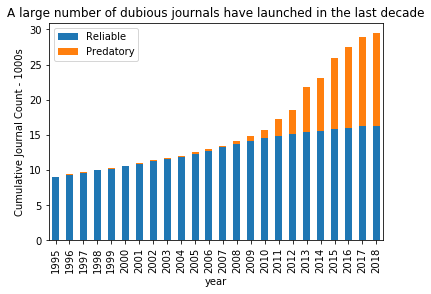

In [3]:
from dodgy_journals_plot import make_plot
dodgy_data_path = r'D:\GitHub\preprintR\data\raw\dodgy_journals.csv'
make_plot(dodgy_data_path)

### The Problem
There is apparently a thriving market for publishing shoddy science, and the peer review process for filtering out this poor quality work is relatively slow. Thus pre-print servers like MedRxiv and BioRxiv are potentially riddled with fraudulent or erroneous papers, wasting critical researcher time. I would like to **develop a tool for automatically flagging these low quality papers**, but first I need to spend some time looking at the raw data to understand what types of features might be usable for solving this problem

### The Dataset

The [CORD-19](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) dataset is a webscraped dataset of nearly 200,000 articles dealing with COVID-19, SARS-COV-2 and related coronaviruses. This is provided as an open source tool through Kaggle, and is a great resource for understanding the evolving literature on this topic.

**Other datasets**

[PMC open access subset](https://www.ncbi.nlm.nih.gov/pmc/tools/openftlist/) is a collection of nearly 2 million scientific articles. These span a much wider range of topics and should be useful for getting a broader understanding of the literature (particularly important for spotting what might be considered bad science)

word vector encodings trained on biomedical research: [1](https://github.com/RaRe-Technologies/gensim-data) [2](http://bioasq.org/news/bioasq-releases-continuous-space-word-vectors-obtained-applying-word2vec-pubmed-abstracts)


## Load and prepare data

In [4]:
root_path = '../../data/raw/CORD19'
metadata_path = f'{root_path}/metadata.csv'
meta_df = pd.read_csv(metadata_path, dtype={'pubmed_id':str, 'Microsoft Academic Paper ID': str, 'doi': str})

C:\Users\Jeff\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (1,5,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
meta_df.head(2)

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [6]:
meta_df.dtypes

cord_uid             object
sha                  object
source_x             object
title                object
doi                  object
pmcid                object
pubmed_id            object
license              object
abstract             object
publish_time         object
authors              object
journal              object
mag_id              float64
who_covidence_id     object
arxiv_id             object
pdf_json_files       object
pmc_json_files       object
url                  object
s2_id               float64
dtype: object

For now, I just want to get a sense of the scope of this dataset. The most interesting pieces for what I'm looking at are the title and abstract (which can get me some idea of the content), the publication date (publish_time), and the journal.

It is also worth pointing out that many of these titles has full text available as part of this dataset, which is linked through the pmc_json_files field. But I don't think that I want to do anything with the full text yet.

In [7]:
meta_df[['cord_uid','title','abstract','publish_time','journal']].isnull().sum()

cord_uid            0
title              50
abstract        51202
publish_time       18
journal          9962
dtype: int64

Looks like we are missing a ton of abstracts, a fair amount of journals, and just a few titles and publish times. I am not particularly worried about any of these except for the publish_time and possible the journal. Cleaning those up a bit.

In [8]:
print(meta_df.shape)
meta_df = meta_df[meta_df['publish_time'].notna()]
meta_df['journal'].fillna('none',inplace = True)
meta_df['title'].fillna('none',inplace = True)
meta_df['abstract'].fillna('none',inplace = True)

print(meta_df.shape)
#extract just the year from the date string
meta_df['publish_year'] = pd.DatetimeIndex(meta_df['publish_time']).year
meta_df[['cord_uid','title','abstract','publish_time','journal','publish_year']].isnull().sum()



(181778, 19)
(181760, 19)


cord_uid        0
title           0
abstract        0
publish_time    0
journal         0
publish_year    0
dtype: int64

In [9]:
meta_df.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,publish_year
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN,2001
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,2000
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,2000
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,2001
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,2001


Now I would just like to see articles by year, and get a sense of what this dataset actually is.

In [10]:
import matplotlib.pyplot as plt

(1980, 2020)

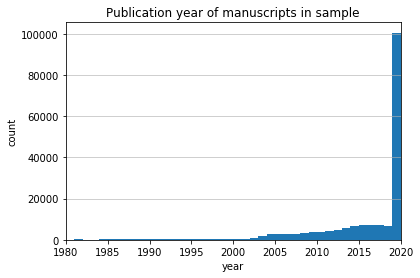

In [11]:
n,bins,patches = plt.hist(x=meta_df['publish_year'],bins=range(1980,2021,1))
plt.grid(axis='y', alpha=0.75)
plt.xlabel('year')
plt.ylabel('count')
plt.title('Publication year of manuscripts in sample')
plt.xlim([1980,2020])

Clearly most of the relevant research on this topic has come out in the last year, but there is still a significant amount of previous research that has been deemed relevant. One thing I'd like to do next is get a sense of what type of research is included in this 'related' category that doesn't deal exactly with COVID-19

In [12]:
# labeling articles which are likely to be directly related to COVID-19
search_terms = str(r'COVID-19|covid|sars cov 2|SARS-CoV-2|2019-nCov|2019 ncov|SARS Coronavirus 2|2019 Novel Coronavirus|coronavirus 2019| Wuhan coronavirus|wuhan pneumonia|wuhan virus')
meta_df['is_covid'] = meta_df.abstract.str.contains(search_terms, case=False) | meta_df.title.str.contains(search_terms, case=False)

In [13]:
print(sum(meta_df.is_covid),'proposed COVID-19 articles vs', sum(meta_df.is_covid==False),'related articles.')

73939 proposed COVID-19 articles vs 107821 related articles.


Now I'd like to look a bit more at what these related articles contain, as a sanity check. First I'll just look at titles because that is faster.

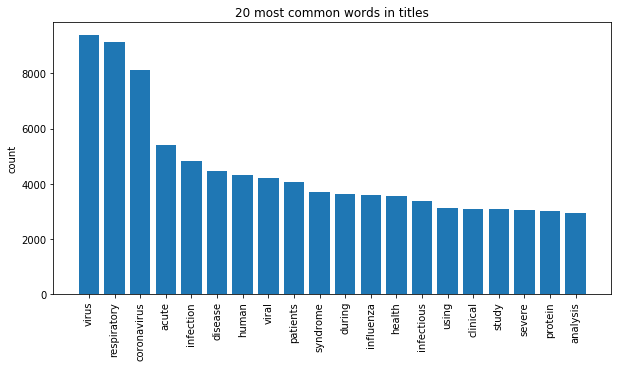

In [66]:
from collections import Counter
#this code is pretty slow
rel_df = meta_df[meta_df['is_covid'] == False]
cov_df = meta_df[meta_df['is_covid'] == True]
all_titles = rel_df.title.str.lower()
all_titles = ' '.join(all_titles)
results = Counter(all_titles.split())
stop_list = {'the','and','to','in','of','a','for','with','on','by','from','an','as','is'} #stripping some common but not useful words
word_list = [(word,count) for [word,count] in results.most_common(40) if word not in stop_list]
word_list = word_list[:20]

word_list = dict(word_list)
plt.figure(figsize=(10,5))
plt.bar(range(len(word_list)), list(word_list.values()), align='center')
plt.xticks(ticks =range(20),labels = word_list.keys(), rotation = 90)
plt.ylabel('count')
plt.title('20 most common words in titles')
plt.show()

The above is a plot of the 20 most common words taken from the 'relevant' dataset. A lot of these are pretty obvious picks seeming to do with respiratory illnesses caused by viruses (including coronaviruses). I think this is a good reference data set to work from, as it is likely that this is the most relevant research for directly comparing to COVID specific research.

For both the relevant and covid datasets, I'm curious about what (if any) journals are showing up most commonly.

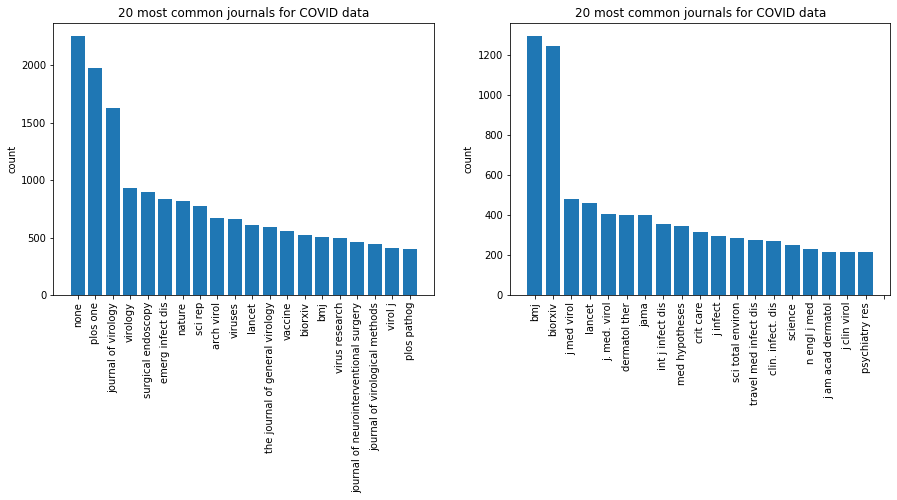

In [70]:
rel_results = Counter(rel_df.journal.str.lower())
stop_list = {''} #will add stop list if needed
word_list = [(word,count) for [word,count] in rel_results.most_common(20) if word not in stop_list]
word_list = dict(word_list)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.bar(range(len(word_list)), list(word_list.values()), align='center')
plt.xticks(ticks =range(20),labels = word_list.keys(),rotation = 90)
plt.ylabel('count')
plt.title('20 most common journals for COVID data')
#now for covid
cov_results = Counter(cov_df.journal.str.lower())
stop_list = {'none'} #including none here because so many unpublished are making it hard to actually see what journals are relevant
word_list = [(word,count) for [word,count] in cov_results.most_common(20) if word not in stop_list]
word_list = dict(word_list)
plt.subplot(1,2,2)
plt.bar(range(len(word_list)), list(word_list.values()), align='center')
plt.xticks(ticks =range(20),labels = word_list.keys(),rotation = 90)
plt.ylabel('count')
plt.title('20 most common journals for COVID data')
plt.show()

I'm not an expert in virology, but I recognize many of these journals in both datasets. The large number of articles posted on biorxiv (a preprint server) is also gratifying, as this is exactly the set of data I'm hoping to address. 
One thing that is very surprising is 1200+ papers from BMJ (British medical journal) for COVID-19. BMJ has a reputation as something of a glamour mag, meaning that they publish a small number of high impact papers every month. To see almost 1300 papers would require publishing 200 a month, and that is just not realistic. In fact all of these numbers are quite high, and so I suspect that my data is not purely coming in the form of research articles.

In [28]:
bmj_df = cov_df.loc[cov_df['journal'].str.lower() == 'bmj']
bmj_df.isnull().sum()

cord_uid               0
sha                 1285
source_x               0
title                  0
doi                  669
pmcid               1272
pubmed_id            680
license                0
abstract               0
publish_time           0
authors               24
journal                0
mag_id              1293
who_covidence_id     595
arxiv_id            1293
pdf_json_files      1285
pmc_json_files      1274
url                  669
s2_id                  1
publish_year           0
is_covid               0
dtype: int64

In [30]:
bmj_df.title.head(20)

12006    Scope, quality, and inclusivity of clinical gu...
26485    Covid-19: school closures and bans on mass gat...
26620    Covid-19: out-of-hours providers are drafted i...
26621    Covid-19: Validity of key studies in doubt aft...
26653    Covid-19: We need to be open about rationing v...
26832    Covid-19: New government study aims to track i...
26861    Covid-19: Local health teams trace eight times...
26932    Covid-19: pandemic healthcare centres should h...
26947                          Waste in covid-19 research.
26984       Public inquiry into UK's response to covid-19.
27010    Covid-19 and ethnicity: it's too early to poin...
27032    Covid-19: UK needs flexible local plans to com...
27482       Covid-19: a remote assessment in primary care.
27506    The Brazilian slums hiring their own doctors t...
27629    Covid-19: ensuring equality of access to testi...
27666    Covid-19: Doctors performing resuscitation nee...
27740    What the Diamond Princess taught the world abo.

One thing I'm noticing is that many of these sound very much like news articles. If so they likely don't have an abstract.

In [39]:
bmj_df.loc[bmj_df.abstract == 'none'].shape[0]

1242

Over 1200! This is many more than I expected, and inspired me to go look at how the bmj publishes content. It looks like this publication is actually mainly news, editorials, and letters rather than scientific research (though they do publish that as well). In fact I'm finding that they put out around 10-20 articles a month. In that case it actually is very reasonable that they might have ~50 research articles specifically dealing with COVID-19, as this has only been a hot research topic for around 6 months at the time of writing and I don't expect that 100% of publications will be about covid. In this case it looks like filtering to only include articles with abstracts might be a win. This is a double benefit, because I am mostly planning on looking at abstracts and titles for this NLP project, and so data which do not contain these are less useful for me in any case.

Armed with this information, I might want to pick a few of the other journals to see if this abstract filter criteria is a good general one.